# nuScenes-lidarseg tutorial

Welcome to the nuScenes-lidarseg tutorial.

This demo assumes that nuScenes is installed at `/data/sets/nuscenes`. The mini version (i.e. v1.0-mini) of the full dataset will be used for this demo.

## Setup
To install the nuScenes-lidarseg expansion, please download the dataset from https://www.nuscenes.org/download. Upon unzipping, you should see two items:
- `lidarseg_v1.0-mini` 
- `v1.0-mini`

Copy both the `lidarseg_v1.0-mini` folder (this contains `.bin` files; each .bin file contains the label of each point in the point cloud) and `v1.0-mini` into `/data/sets/nuscenes`. If you already have an existing `v1.0-mini` folder from nuScenes, it is safe to replace it as the `v1.0-mini` from nuScenes-lidarseg will have the required files as well. 

If you have downloaded `v1.0-trainval` and `v1.0-test` for nuScenes-lidarseg as well, place (or replace) them in `/data/sets/nuscenes`. 

Essentially, your `/data/sets/nuscenes` folder should end up looking like this:
```
└── nuscenes  
    ├── Usual nuscenes folders (i.e. samples, sweep)
    │
    ├── lidarseg_v1.0-{mini, trainval} <- Contains the .bin files (Note that v1.0-test does not 
    │                                     have any .bin files associated with it.
    │
    └── v1.0-{mini, trainval, test}
        ├── Usual files (e.g. attribute.json, calibrated_sensor.json etc.)     
        ├── lidarseg.json  <- contains the mapping of each .bin file to the token  
        └── lidarseg_category.json <- contains the categories of the labels
```

## Initialization
Let's start by importing the necessary libraries:

In [1]:
%matplotlib inline

from nuscenes import NuScenes

nusc = NuScenes(version='v1.0-mini', dataroot='/data/sets/nuscenes', verbose=True)

Loading NuScenes tables for version v1.0-mini...
Loading nuScenes-lidarseg...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
404 lidarseg,
Done loading in 0.4 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.


As you can see, you do not need any extra libraries to use nuScenes-lidarseg. The original nuScenes devkit which you are familiar with has been extended so that you can use it seamlessly with nuScenes-lidarseg.

## Statistics of lidarseg dataset for the v1.0-mini split
Let's get a quick feel of the lidarseg dataset by looking at what classes are in it and the number of points belonging to each class. The classes will be sorted in ascending order based on the number of points.

In [2]:
nusc.list_lidarseg_categories()

Calculating stats for nuScenes-lidarseg...
  0  unused                              nbr_points=           0
  9  train                               nbr_points=           0
 10  police_vehicle                      nbr_points=           0
 11  firetruck                           nbr_points=           0
 12  ambulance                           nbr_points=           0
 14  police_motorcycle                   nbr_points=           0
 16  police_bicycle                      nbr_points=           0
 22  traffic_police                      nbr_points=           0
 24  stroller                            nbr_points=           0
 25  wheelchair                          nbr_points=           0
 26  small_animal                        nbr_points=           0
 27  large_animal                        nbr_points=           0
 41  bike_pedestrian_traffic_light_box   nbr_points=           0
 40  vehicle_traffic_light_box           nbr_points=           3
 31  movable_obstacle_in_road            nbr_po

## Pick a sample token
Let's pick a sample token to use for this tutorial.

In [3]:
my_sample = nusc.sample[87]

## Get statistics of a lidarseg sample token
Let's pick a lidarseg sample token and take a look at what objects are present in this particular sample.

In [4]:
nusc.get_sample_lidarseg_stats(my_sample['token'], sort_counts=True)

===== Statistics for 6dabc0fb1df045558f802246dd186b3f =====
 15  bicycle                             n=           9
 30  pushable_pullable_object            n=          11
 39  noise                               n=          62
 19  adult_pedestrian                    n=          71
  3  pickup_truck                        n=         103
  8  rigid_bus                           n=         105
 29  temporary_traffic_barrier           n=         280
  5  trailer                             n=         302
 37  foliage_including_tree_and_bushes   n=         330
  4  front_of_semi_truck                 n=       1,126
 33  sidewalk                            n=       1,310
 35  other_flat                          n=       1,495
  1  car_or_van_or_suv                   n=       3,291
 36  man_made                            n=       4,650
 32  driveable_surface                   n=       9,884
 38  other_static_object                 n=      11,723


By doing ```sort_counts=True```, the classes and their respective frequency counts are printed in ascending order; On the other hand, ```sort_counts=False``` will print the classes and their respective frequency counts in alphabetical order.

## Render the lidarseg labels in the bird's eye view of a pointcloud
In the original nuScenes devkit, you would pass a sample data token into ```render_sample_data``` to render a bird's eye view of the pointcloud. However, the points would be colored according to the distance from the ego vehicle. Now with the extended nuScenes devkit, all you need to do is set ```show_lidarseg_labels=True``` to visualize the class labels of the pointcloud.

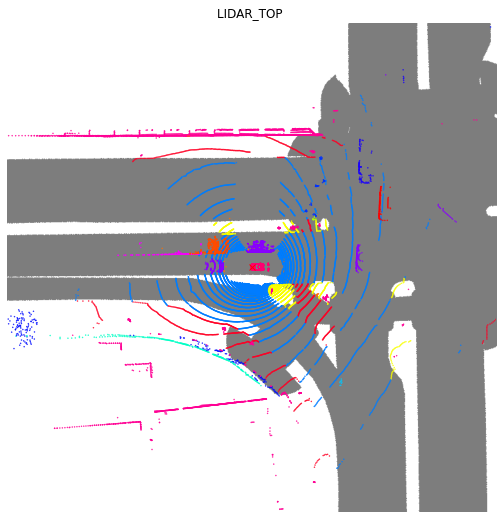

In [5]:
sample_data_token = my_sample['data']['LIDAR_TOP']
nusc.render_sample_data(sample_data_token,
                        with_anns=False,
                        show_lidarseg_labels=True)

But what if you wanted to focus on only certain classes? Given the statistics of the pointcloud printed out previously, let's say you are only interested in trucks and trailers. You could see the class indices belonging to those classes from the statistics and then pass an array of those indices into ```filter_lidarseg_labels``` like so:

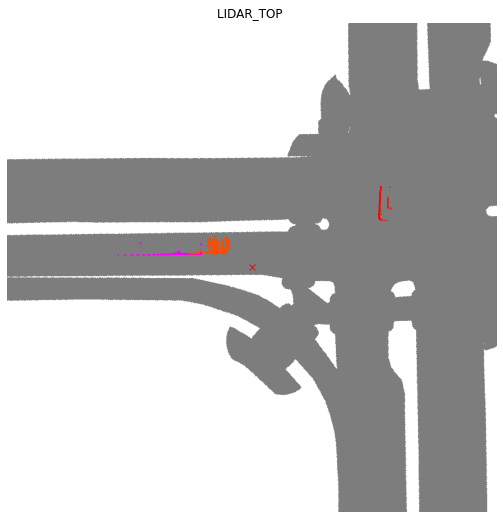

In [6]:
nusc.render_sample_data(sample_data_token,
                        with_anns=False,
                        show_lidarseg_labels=True,
                        filter_lidarseg_labels=[3, 4, 5])

Now only points in the pointcloud belonging to trucks and trailers are filtered out for your viewing pleasure. 

## Render lidarseg labels in image
If you wanted to superimpose the pointcloud into the corresponding image from a camera, you can use ```render_pointcloud_in_image``` like what you would do with the original nuScenes devkit, but set ```show_lidarseg_labels=True``` (remember to set ```render_intensity=False```). Similar to ```render_sample_data```, you can filter to see only certain classes using ```filter_lidarseg_labels```. And you can use ```show_lidarseg_legend``` to display a legend in the rendering.

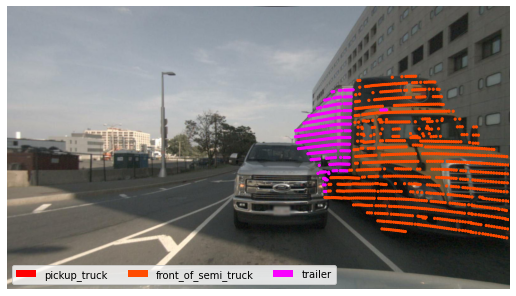

In [7]:
nusc.render_pointcloud_in_image(my_sample['token'],
                                pointsensor_channel='LIDAR_TOP',
                                camera_channel='CAM_BACK',
                                render_intensity=False,
                                show_lidarseg_labels=True,
                                filter_lidarseg_labels=[3, 4, 5],
                                show_lidarseg_legend=True,
                                verbose=True)

Say you happen to choose a camera channel where there are no points to show after filtering; you can set ```render_if_no_points=False``` so that nothing is displayed / saved in this case. For example, if we filter to see bicycles and objects which are pushable or pullable, and there are no points belonging to those classes, then:

In [8]:
nusc.render_pointcloud_in_image(my_sample['token'],
                                pointsensor_channel='LIDAR_TOP',
                                camera_channel='CAM_BACK',
                                render_intensity=False,
                                show_lidarseg_labels=True,
                                filter_lidarseg_labels=[30, 15],
                                show_lidarseg_legend=True,
                                verbose=True,
                                render_if_no_points=False)

No points in LIDAR_TOP which are present in CAM_BACK image (sample_token = 6dabc0fb1df045558f802246dd186b3f)


This might be useful when you want to render a bunch of sample tokens, but only for those which contain useful information (i.e. points belonging to certain classes) in them.

## Render sample (i.e. lidar, radar and all cameras)
Of course, like in the original nuScenes devkit, you can render all the sensors at once with ```render_sample```. In this extended nuScenes devkit, you can set ```show_lidarseg_labels=True``` to see the lidarseg labels. Similar to the above methods, you can use ```filter_lidarseg_labels``` to display only the classes you wish to see.

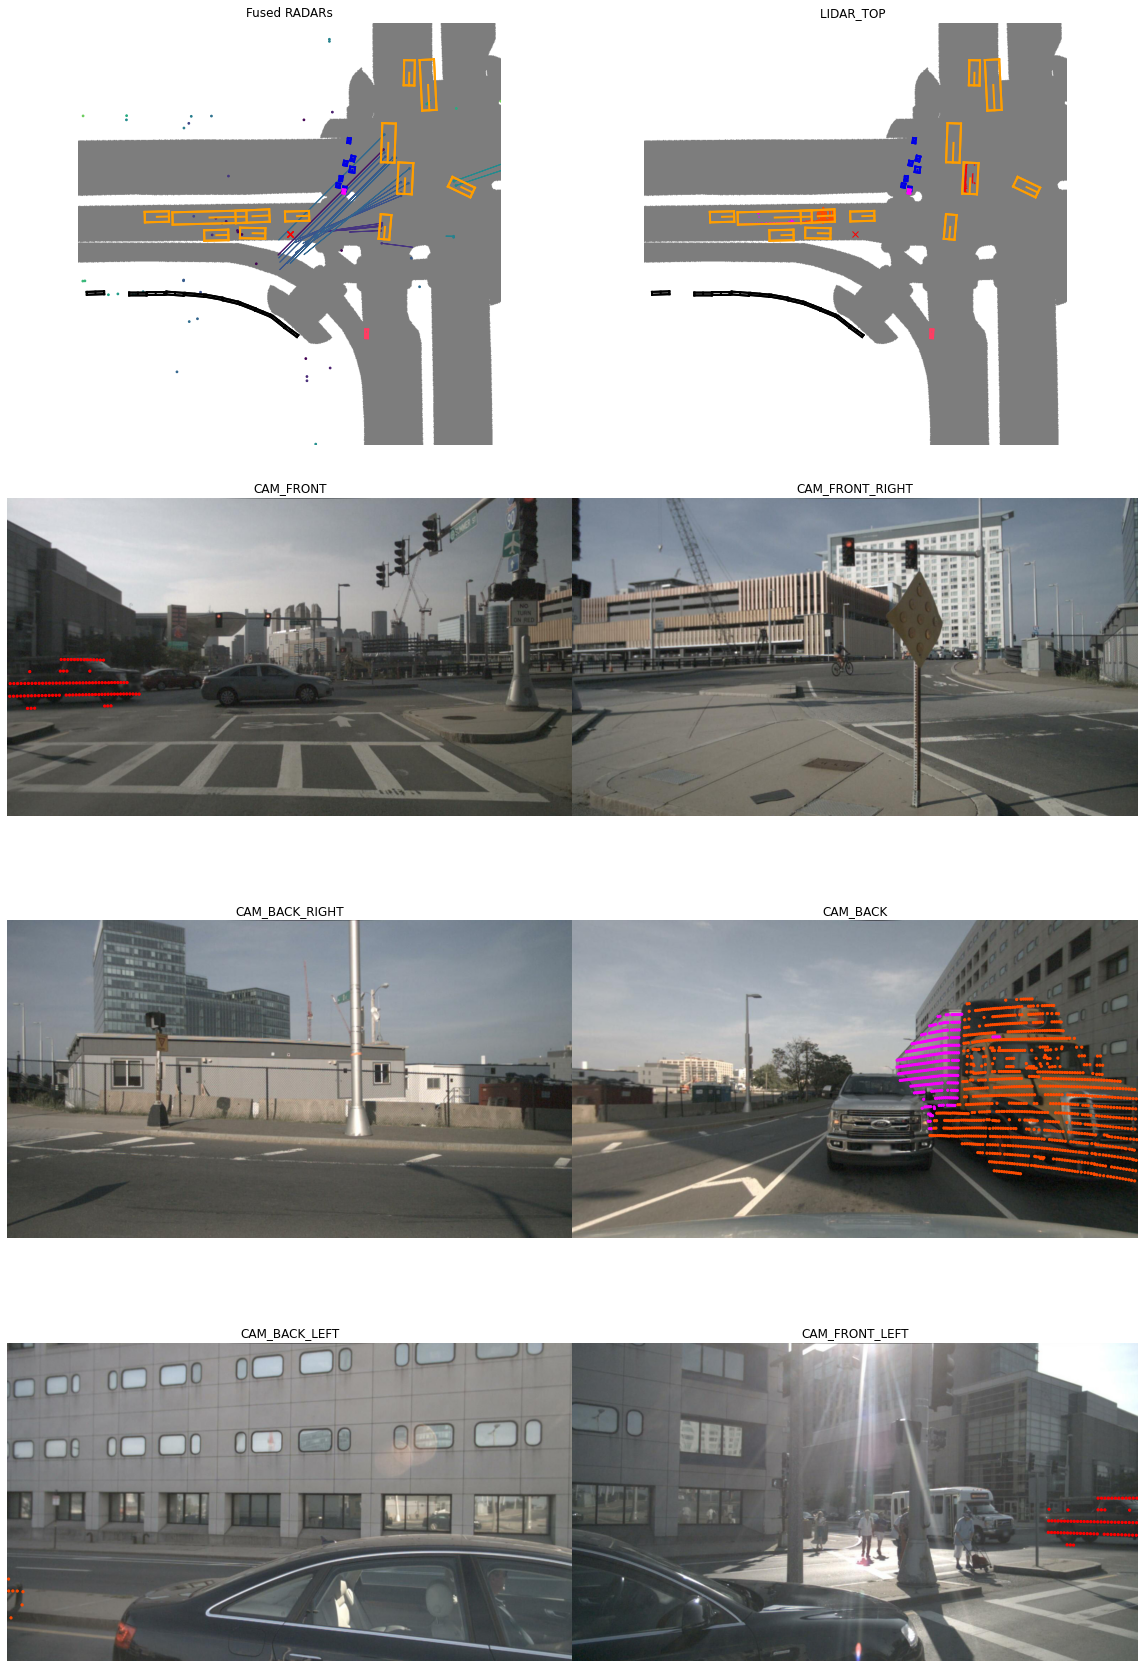

In [9]:
nusc.render_sample(my_sample['token'],
                   show_lidarseg_labels=True,
                   filter_lidarseg_labels=[3, 4, 5],
                   verbose=True)

## Render a scene for a given camera sensor with lidarseg labels
You can also render an entire scene with the lidarseg labels for a camera of your choosing (the ```filter_lidarseg_labels``` and ```render_if_no_points``` arguments are present here as well).

Let's pick a scene first:

In [13]:
my_scene = nusc.scene[0]

We then pass the scene token into ```render_camera_channel_with_pointclouds``` indicating that we are only interested in construction vehicles and man-made objects.

(Note: the following code is commented out as it crashes in Jupyter notebooks.)

In [14]:
# import os
# nusc.render_camera_channel_with_pointclouds(my_scene['token'], 
#                                             'CAM_BACK', 
#                                             filter_lidarseg_labels=[6, 36],
#                                             render_if_no_points=True, 
#                                             verbose=True, 
#                                             imsize=(1280, 720))

To save the renderings as images, you can pass a path to a folder you want to save the images to via the ```out_folder``` argument.

(Note: the following code is commented out as it crashes in Jupyter notebooks.)

In [ ]:
# nusc.render_camera_channel_with_pointclouds(my_scene['token'], 'CAM_BACK',
#                                             filter_lidarseg_labels=[6, 36],
#                                             render_if_no_points=True,
#                                             verbose=True,
#                                             imsize=(1280, 720),
#                                             out_folder=os.path.expanduser('~/Desktop/my_folder'))

Alternatively, to save the renderings into a video, all you have to do is pass a path ending in a ```.avi``` extension to ```out_folder```. Here, we filter to show only points belonging to construction vehicles.

(Note: the following code is commented out as it crashes in Jupyter notebooks.)

In [ ]:
# nusc.render_camera_channel_with_pointclouds(my_scene['token'], 'CAM_BACK',
#                                             filter_lidarseg_labels=[6],
#                                             render_if_no_points=True,
#                                             verbose=True,
#                                             imsize=(1280, 720),
#                                             out_folder=os.path.expanduser('~/Desktop/my_rendered_scene.avi'))

## Render a scene for all cameras with lidarseg labels
You can also render the entire scene for all cameras at once with the lidarseg labels as a video. Let's say in this case, we are interested in points belonging to driveable surfaces and cars.

(Note: the following code is commented out as it crashes in Jupyter notebooks.)

In [ ]:
# nusc.render_scene_with_pointclouds_for_all_cameras(my_scene['token'], 
#                                                    filter_lidarseg_labels=[32, 1],
#                                                    out_path=os.path.expanduser('~/Desktop/my_rendered_scene.avi'))

## Visualizing LIDAR segmentation predictions
In all the above functions, the labels of the LIDAR pointcloud which have been rendered are the ground truth. If you have trained a model to segment LIDAR pointclouds and have run it on the nuScenes-lidarseg dataset, you can visualize your model's predictions with nuScenes-lidarseg as well!

You simply need to pass the path to the .bin file where your predictions for the given sample are to `lidarseg_preds_bin_path` for these functions:
- `render_sample_data`
- `render_pointcloud_in_image`
- `render_sample`                 

For example, let's assume the predictions for `my_sample` is stored at `/data/sets/nuscenes/lidarseg` with the format `<lidar_sample_data_token>_lidarseg.bin`:

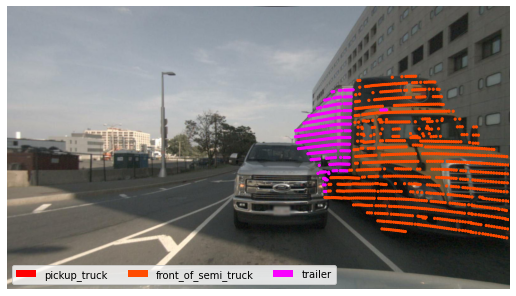

In [12]:
import os

my_sample = nusc.sample[87]
sample_data_token = my_sample['data']['LIDAR_TOP']
my_predictions_bin_file = os.path.join('/data/sets/nuscenes/lidarseg_v1.0-mini', sample_data_token + '_lidarseg.bin')

nusc.render_pointcloud_in_image(my_sample['token'],
                                pointsensor_channel='LIDAR_TOP',
                                camera_channel='CAM_BACK',
                                render_intensity=False,
                                show_lidarseg_labels=True,
                                filter_lidarseg_labels=[3, 4, 5],
                                show_lidarseg_legend=True,
                                verbose=True,
                                lidarseg_preds_bin_path=my_predictions_bin_file)

For these functions that render an entire scene, you will need to pass the path to the folder which contains the .bin files for each sample in a scene to `lidarseg_preds_folder`:
- `render_camera_channel_with_pointclouds`
- `render_scene_with_pointclouds_for_all_cameras`

Pay special attention that **each set of predictions in the folder _must_ be a `.bin` file and named as `<lidar_sample_data_token>_lidarseg.bin`**.

(Note: the following code is commented out as it crashes in Jupyter notebooks.)

In [ ]:
# my_scene = nusc.scene[0]
# my_folder_of_predictions = '/data/sets/nuscenes/lidarseg_v1.0-mini'

# nusc.render_camera_channel_with_pointclouds(my_scene['token'], 
#                                             'CAM_BACK', 
#                                             filter_lidarseg_labels=[6, 36],
#                                             render_if_no_points=True, 
#                                             verbose=True, 
#                                             imsize=(1280, 720),
#                                             lidarseg_preds_folder=my_folder_of_predictions)

## Conclusion
And this brings us to the end of the tutorial for nuScenes-lidarseg, enjoy!